In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

FAST_MODE = True        # True = quicker experiments, False = full dataset run
SAMPLE_FRAC = 0.25

sns.set_theme(style="whitegrid")


**Interpretation **

This cell imports all libraries for data handling, visualization, machine learning, and evaluation. A fixed random seed is used so results are reproducible (same split and similar outcomes each run). FAST_MODE allows faster testing by sampling the dataset.

In [ ]:
df = pd.read_csv("adult.csv", na_values=["?"])
print("Shape:", df.shape)
display(df.head())

df = df.copy()

# Clean whitespace for text columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()
    df.loc[df[c].str.lower() == "nan", c] = np.nan

# Ensure pandas NA becomes numpy nan (sklearn-friendly)
df = df.replace({pd.NA: np.nan})

TARGET = "income"
y_full = (df[TARGET] == ">50K").astype(int)
X_full = df.drop(columns=TARGET)


Shape: (38464, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


Interpretation:
Here we load the dataset and handle missing values (the dataset uses ? as missing). We also remove extra spaces from categorical values (like " Private"), which improves encoding quality. The target (income) is converted into binary classes: 1 for >50K and 0 for <=50K.

In [ ]:
#Stratified Sampling + Data Quality Check
if FAST_MODE:
    tmp = X_full.copy()
    tmp["_y"] = y_full

    # stratified sampling (keeps class ratio similar)
    tmp = tmp.groupby("_y", observed=True).sample(
        frac=SAMPLE_FRAC,
        random_state=RANDOM_STATE
    )
    y = tmp["_y"]
    X = tmp.drop(columns="_y")
    print(f"FAST_MODE=True → using {len(X):,} rows")
else:
    X, y = X_full, y_full
    print(f"FAST_MODE=False → using full dataset: {len(X):,} rows")

labels = {0: "<=50K", 1: ">50K"}
display(pd.DataFrame({
    "Class": [labels[i] for i in y.value_counts().sort_index().index],
    "Count": y.value_counts().sort_index().values,
    "Percent": (y.value_counts(normalize=True).sort_index() * 100).round(2).values
}))

missing_pct = (X.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct[missing_pct > 0].round(2).to_frame("Missing %"))

print("Duplicate rows in raw df:", df.duplicated().sum())


FAST_MODE=True → using 9,616 rows


,Class,Count,Percent
0,<=50K,7334,76.27
1,>50K,2282,23.73


,Missing %
occupation,5.89
workclass,5.87
native-country,1.83


Duplicate rows in raw df: 33


Interpretation:
This cell checks dataset quality. The target distribution shows class imbalance (more <=50K than >50K), so F1-score and recall become important, not just accuracy. We also measure missing values and duplicates to understand cleaning needs.

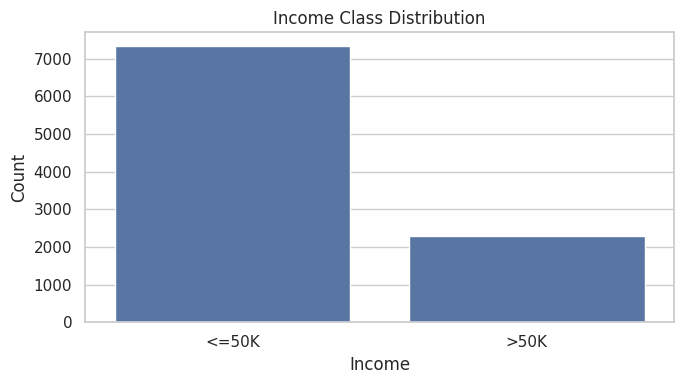

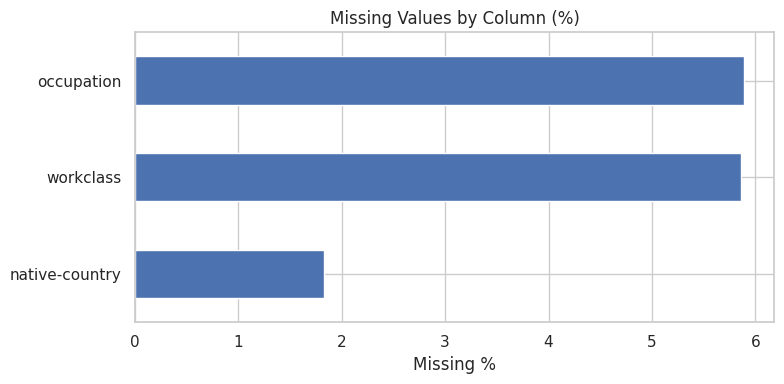

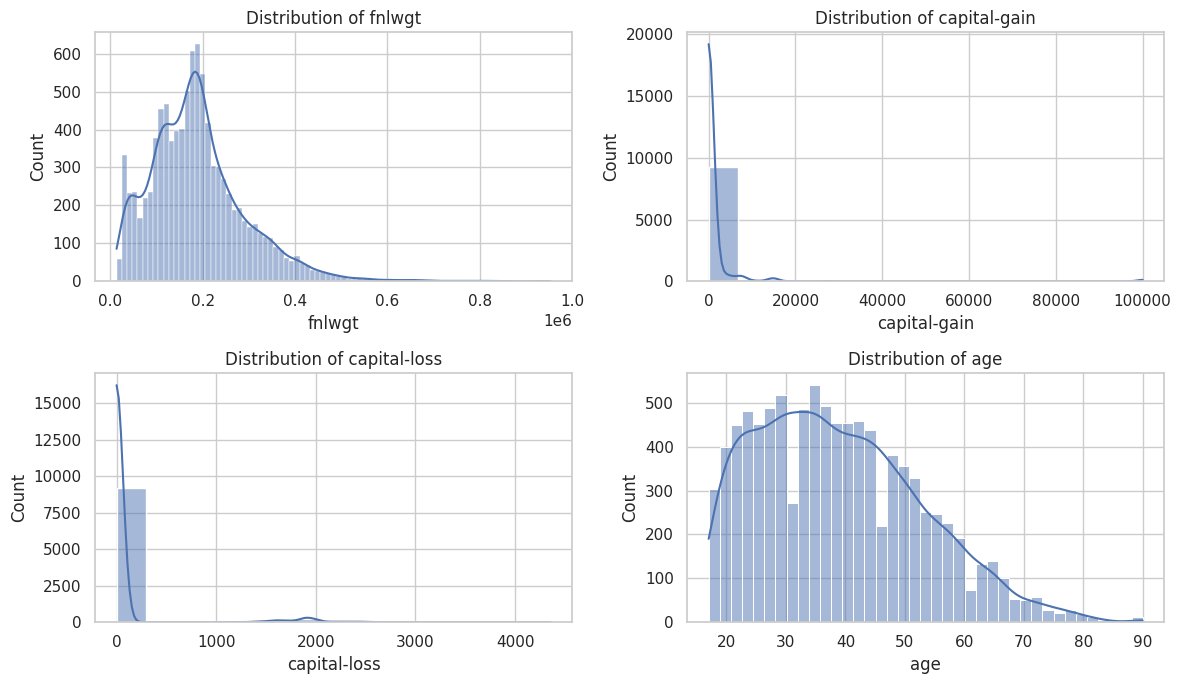

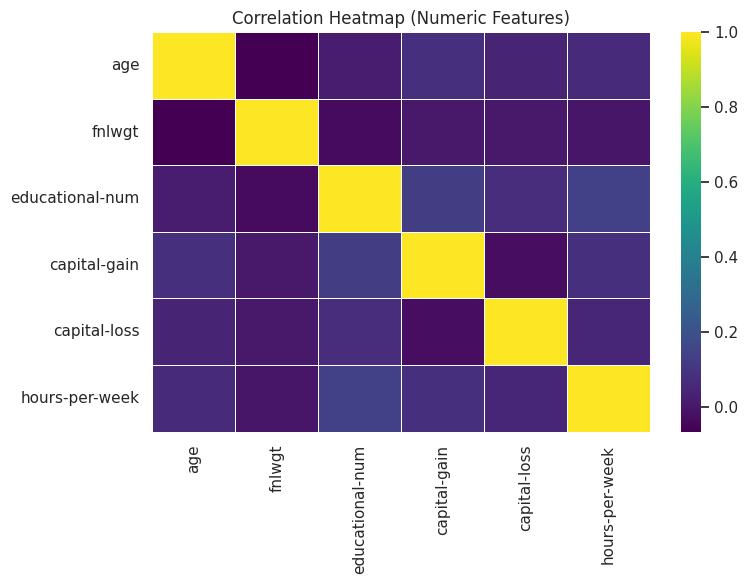

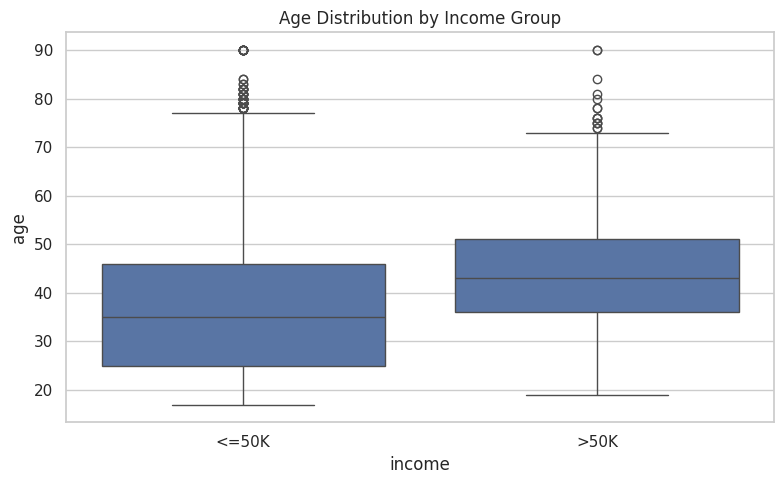

In [ ]:
#EDA Visualizations
# Target distribution
plt.figure(figsize=(7,4))
sns.countplot(x=y.map(labels))
plt.title("Income Class Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Missingness
miss_nonzero = missing_pct[missing_pct > 0].sort_values()
if len(miss_nonzero) > 0:
    plt.figure(figsize=(8,4))
    miss_nonzero.plot(kind="barh")
    plt.title("Missing Values by Column (%)")
    plt.xlabel("Missing %")
    plt.tight_layout()
    plt.show()

# Feature types
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# Numeric distributions (top 4 by variance)
if len(num_cols) > 0:
    top_num = X[num_cols].var(numeric_only=True).sort_values(ascending=False).head(4).index.tolist()
    fig, axes = plt.subplots(2, 2, figsize=(12,7))
    axes = axes.ravel()
    for i, col in enumerate(top_num):
        sns.histplot(X[col], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# Correlation heatmap (numeric)
if len(num_cols) >= 2:
    plt.figure(figsize=(8,6))
    sns.heatmap(X[num_cols].corr(numeric_only=True), cmap="viridis", linewidths=0.5)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# Age vs income
if "age" in X.columns:
    tmp_plot = X.copy()
    tmp_plot["income"] = y.map(labels)
    plt.figure(figsize=(8,5))
    sns.boxplot(data=tmp_plot, x="income", y="age")
    plt.title("Age Distribution by Income Group")
    plt.tight_layout()
    plt.show()


Interpretation:
These plots help understand patterns before modeling. The class distribution confirms imbalance. Missingness plots show where imputation is needed (e.g., workclass/occupation). The boxplot suggests people earning >50K tend to have a higher median age, and the correlation heatmap shows relationships among numeric features.

In [ ]:
#Train/Test Split + Preprocessing Pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test:", X_train.shape, X_test.shape)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])



Train/Test: (7692, 14) (1924, 14)


Interpretation:
We split into train and test sets using stratification so the income class ratio stays similar in both splits. Then we build a preprocessing pipeline: numeric features are imputed with median and scaled, while categorical features are imputed with the most frequent value and one-hot encoded.


Logistic Regression (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      1467
        >50K       0.70      0.58      0.64       457

    accuracy                           0.84      1924
   macro avg       0.79      0.75      0.77      1924
weighted avg       0.83      0.84      0.84      1924



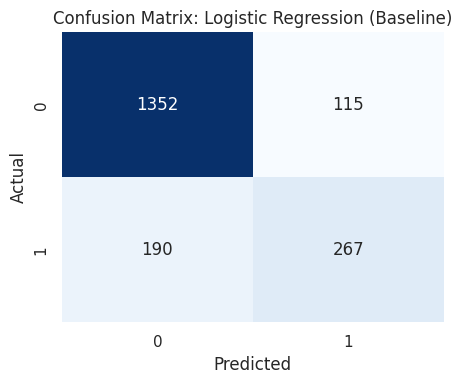


Random Forest (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      1467
        >50K       0.70      0.59      0.64       457

    accuracy                           0.84      1924
   macro avg       0.79      0.76      0.77      1924
weighted avg       0.84      0.84      0.84      1924



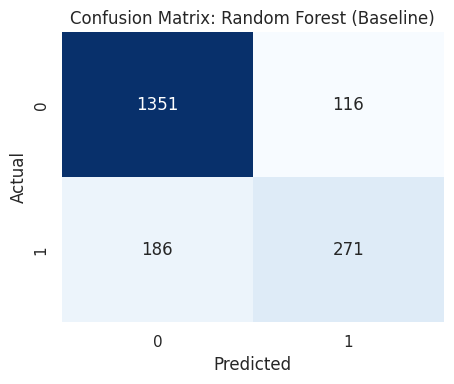


Neural Network MLP (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      1467
        >50K       0.69      0.58      0.63       457

    accuracy                           0.84      1924
   macro avg       0.78      0.75      0.76      1924
weighted avg       0.83      0.84      0.83      1924



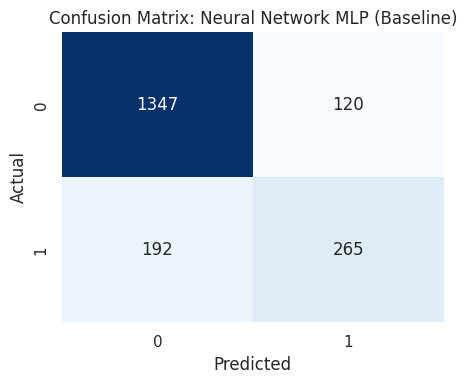

,Model,Accuracy,Precision,Recall,F1
1,Random Forest (Baseline),0.8430,0.7003,0.5930,0.6422
0,Logistic Regression (Baseline),0.8415,0.6990,0.5842,0.6365
2,Neural Network MLP (Baseline),0.8378,0.6883,0.5799,0.6295


In [ ]:
#Baseline Models (2 Classical + 1 Neural Network) + Evaluation
def evaluate(model, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print(f"\n{name}")
    print(classification_report(y_test, pred, target_names=["<=50K", ">50K"], zero_division=0))

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4.7,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
    }

logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1, random_state=RANDOM_STATE))
])

rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE))
])

mlp = Pipeline([
    ("prep", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        early_stopping=True,
        max_iter=40 if FAST_MODE else 100,
        random_state=RANDOM_STATE
    ))
])

baseline = []
baseline.append(evaluate(logreg, "Logistic Regression (Baseline)"))
baseline.append(evaluate(rf, "Random Forest (Baseline)"))
baseline.append(evaluate(mlp, "Neural Network MLP (Baseline)"))

baseline_df = pd.DataFrame(baseline).sort_values("F1", ascending=False)
display(baseline_df.round(4))


In [ ]:
#Task 4: Hyperparameter Tuning (GridSearchCV)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs_lr = GridSearchCV(
    logreg,
    {"clf__C": [0.1, 1, 5], "clf__class_weight": [None, "balanced"]},
    scoring="f1", cv=cv, n_jobs=-1
)
gs_lr.fit(X_train, y_train)

gs_rf = GridSearchCV(
    rf,
    {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 20],
        "clf__min_samples_split": [2, 10]
    },
    scoring="f1", cv=cv, n_jobs=-1
)
gs_rf.fit(X_train, y_train)

best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_

print("Best LR params:", gs_lr.best_params_, "CV F1:", round(gs_lr.best_score_, 4))
print("Best RF params:", gs_rf.best_params_, "CV F1:", round(gs_rf.best_score_, 4))


Best LR params: {'clf__C': 1, 'clf__class_weight': 'balanced'} CV F1: 0.6781
Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 10, 'clf__n_estimators': 200} CV F1: 0.6567


Interpretation:
Hyperparameter tuning tries multiple settings using cross-validation and selects the best based on F1-score. This improves reliability because results are averaged across multiple folds rather than depending on a single train/test split.


Final Logistic Regression
              precision    recall  f1-score   support

       <=50K       0.93      0.80      0.86      1467
        >50K       0.55      0.81      0.66       457

    accuracy                           0.80      1924
   macro avg       0.74      0.80      0.76      1924
weighted avg       0.84      0.80      0.81      1924



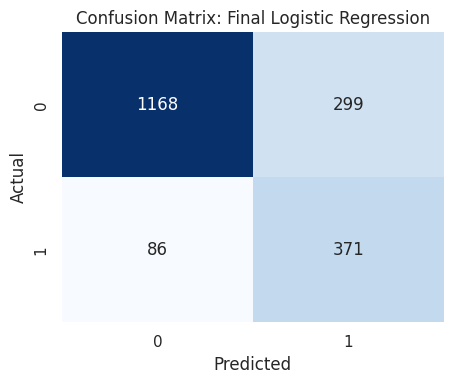


Final Random Forest
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      1467
        >50K       0.73      0.56      0.64       457

    accuracy                           0.85      1924
   macro avg       0.80      0.75      0.77      1924
weighted avg       0.84      0.85      0.84      1924



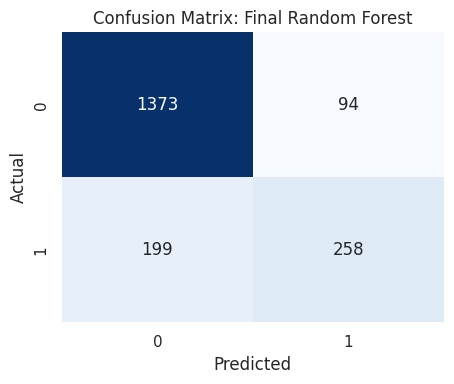

,Model,Accuracy,Precision,Recall,F1,CV F1
0,Final Logistic Regression,0.7999,0.5537,0.8118,0.6584,0.6775
1,Final Random Forest,0.8477,0.7330,0.5646,0.6378,0.6522


In [ ]:
#Task 5 & 6: Feature Selection + Final Models + Comparison Table
# Feature selection (embedded methods)
lr_fs = Pipeline([
    ("prep", preprocess),
    ("select", SelectFromModel(
        LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=3000, random_state=RANDOM_STATE)
    )),
    ("clf", best_lr.named_steps["clf"])
])

rf_fs = Pipeline([
    ("prep", preprocess),
    ("select", SelectFromModel(
        RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
    )),
    ("clf", best_rf.named_steps["clf"])
])

final_results = []

for model, name in [(lr_fs, "Final Logistic Regression"), (rf_fs, "Final Random Forest")]:
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
    metrics = evaluate(model, name)
    metrics["CV F1"] = cv_f1
    final_results.append(metrics)

final_table = pd.DataFrame(final_results).round(4)
display(final_table.sort_values("F1", ascending=False))


Interpretation:
Feature selection reduces the number of features by keeping the most important ones. This can improve generalization and reduce noise. The final models combine: (1) best hyperparameters from tuning and (2) selected features. The final table compares models using CV F1 and test metrics.